In [1]:
%load_ext autoreload
%autoreload 2

### Load diagnostics

In [2]:
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
gridname = 'natv' #   choose from ['natv', 'rho2', 'zstr']
dt = 'monthly' #       choose from ['monthly', 'daily', 'hourly']

In [4]:
# Load data on native grid
sim = "wmt_incsurffluxes.natv_rho2_zstr.monthly_daily_hourly.13months"
rootdir = f"/archive/Graeme.Macgilchrist/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/{sim}/Baltic_OM4_025/"
prefix = '19000101.ocean_'+dt+'_'
time = "190*"

# Diagnostics were saved into different files
suffixs = ['surf','thck','heat','salt','xtra']
Zprefixes = {'rho2':'rho2_', 'zstr':'z_', 'natv':'z'}
Zprefix = Zprefixes[gridname]
ds = xr.Dataset()
for suffix in suffixs:
    if suffix == "surf":
        filename = prefix+suffix+'_'+time+'.nc'
    else:
        filename = prefix+gridname+'_'+suffix+'_'+time+'.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])

### Load budget metadata

In [5]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6").copy()

We load in the file `xbudget/conventions/MOM6.yaml`, which comprehensively details the mass, heat, and salt budgets in MOM6, and how they can be evaluated using various combinations of diagnostics.

In [6]:
import json
print(json.dumps(budgets_dict['heat'], sort_keys=True, indent=4))

{
    "lambda": "thetao",
    "lhs": {
        "sum": {
            "Eulerian_tendency": "opottemptend",
            "var": null
        },
        "var": null
    },
    "rhs": {
        "sum": {
            "advection": {
                "sum": {
                    "horizontal": {
                        "finite_difference": {
                            "X": "T_adx",
                            "Y": "T_ady"
                        },
                        "var": "T_advection_xy"
                    },
                    "var": null,
                    "vertical": "Th_tendency_vert_remap"
                },
                "var": null
            },
            "bottom_flux": "internal_heat_heat_tendency",
            "diffusion": {
                "sum": {
                    "horizontal": {
                        "finite_difference": {
                            "X": "T_diffx",
                            "Y": "T_diffy"
                        },
                        "var

The `var: null` entries in the dictionary denote where diagnostics are not directly available. In many cases, however, they can be reconstructed by taking the sum or product of available diagnostics.

We can use the `xbudget.collect_budgets` function to leverage the information in this metadata dictionary to fill in all of these gaps in the budget.

In [7]:
xbudget.collect_budgets(ds, budgets_dict)

 All of these reconstructed budget terms are also automatically added to the original dataset, so they can be used directly to evaluate the budget.

In [8]:
import json
print(json.dumps(budgets_dict['heat'], sort_keys=True, indent=4))

{
    "lambda": "thetao",
    "lhs": {
        "sum": {
            "Eulerian_tendency": "opottemptend",
            "var": "heat_lhs_sum"
        },
        "var": "heat_lhs_sum"
    },
    "rhs": {
        "sum": {
            "advection": {
                "sum": {
                    "horizontal": {
                        "finite_difference": {
                            "X": "T_adx",
                            "Y": "T_ady"
                        },
                        "var": "T_advection_xy"
                    },
                    "var": "heat_rhs_advection_sum",
                    "vertical": "Th_tendency_vert_remap"
                },
                "var": "heat_rhs_advection_sum"
            },
            "bottom_flux": "internal_heat_heat_tendency",
            "diffusion": {
                "sum": {
                    "horizontal": {
                        "finite_difference": {
                            "X": "T_diffx",
                            "Y": "T_di

### Verification that the budgets close

We compare the left-hand-side (LHS) tendency terms against the sum of all of the right-hand-side (RHS) terms. 

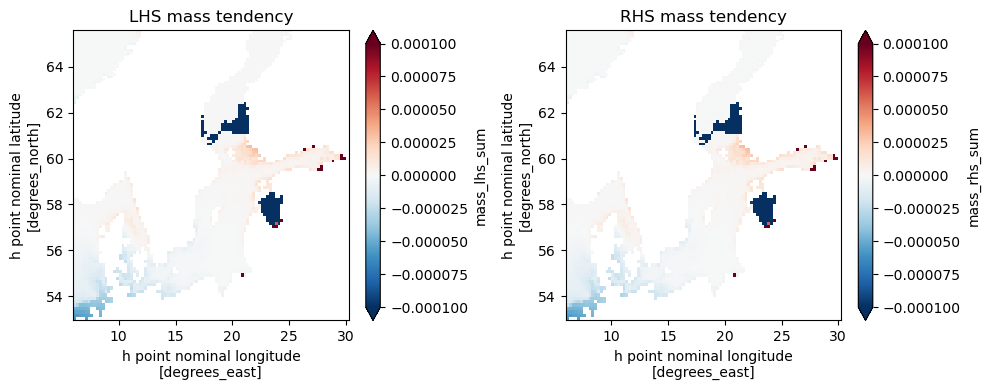

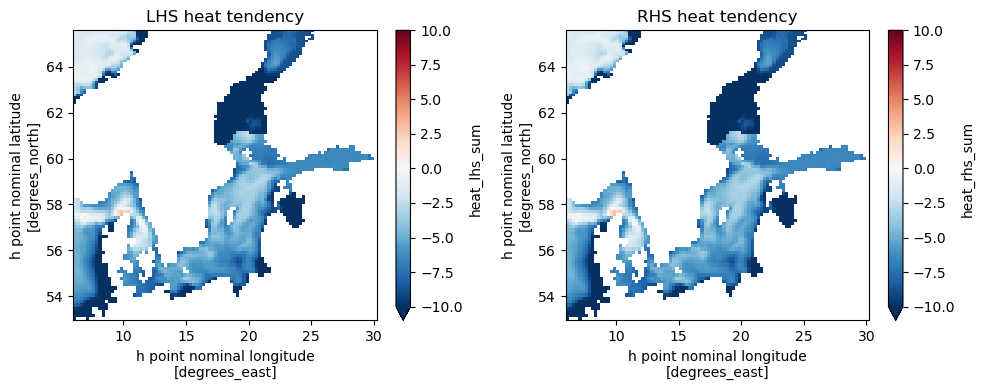

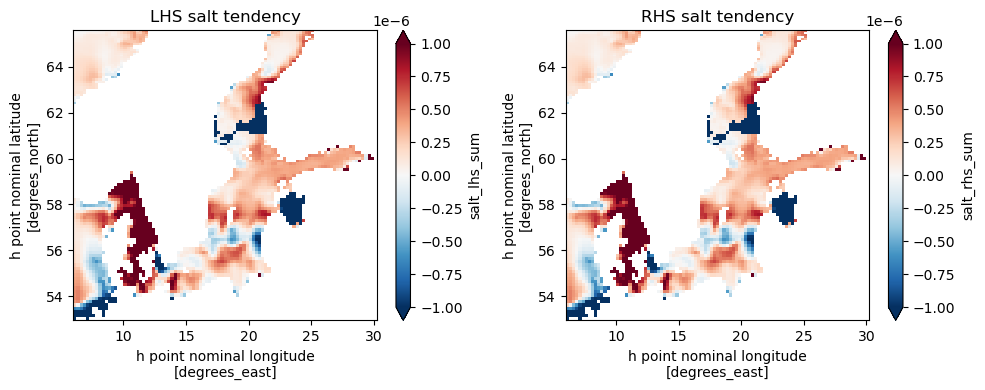

In [9]:
for eq, vmax in zip(["mass", "heat", "salt"], [1.e-4, 10, 1.e-6]):
    plt.figure(figsize=(10, 4))

    plt.subplot(1,2,1)
    ds[budgets_dict[eq]['lhs']['var']].isel(zl = 0).isel(time=0).plot(vmin=-vmax, vmax=vmax, cmap="RdBu_r")
    plt.title(f"LHS {eq} tendency")
    
    plt.subplot(1,2,2)
    ds[budgets_dict[eq]['rhs']['var']].isel(zl = 0).isel(time=0).plot(vmin=-vmax, vmax=vmax, cmap="RdBu_r")
    plt.title(f"RHS {eq} tendency")

    plt.tight_layout()

### Decompose RHS budget terms with `xbudget`

Since the full budget is relatively clunky and can be decomposed in a number of different ways, we include helper functions for aggregating them into just a few high-level terms:

In [10]:
simple_budgets = xbudget.aggregate(budgets_dict)
simple_budgets

{'mass': {'lambda': 'density',
  'thickness': 'thkcello',
  'lhs': {'Eulerian_tendency': 'mass_lhs_Eulerian_tendency_product'},
  'rhs': {'advection': 'mass_rhs_advection_sum', 'surface_flux': 'wfo'}},
 'heat': {'lambda': 'thetao',
  'surface_lambda': 'tos',
  'lhs': {'Eulerian_tendency': 'opottemptend'},
  'rhs': {'advection': 'heat_rhs_advection_sum',
   'diffusion': 'heat_rhs_diffusion_sum',
   'surface_flux': 'boundary_forcing_heat_tendency',
   'bottom_flux': 'internal_heat_heat_tendency',
   'frazil_ice': 'frazil_heat_tendency'},
  'surface_advective_ocean_flux': {'surface_advective_ocean_flux': 'heat_surface_advective_ocean_flux_product'}},
 'salt': {'lambda': 'so',
  'surface_lambda': 'sos',
  'lhs': {'Eulerian_tendency': 'osalttend'},
  'rhs': {'advection': 'salt_rhs_advection_sum',
   'diffusion': 'salt_rhs_diffusion_sum',
   'surface_flux': 'boundary_forcing_salt_tendency'},
  'surface_advective_ocean_flux': {'surface_advective_ocean_flux': 'salt_surface_advective_ocean_flux

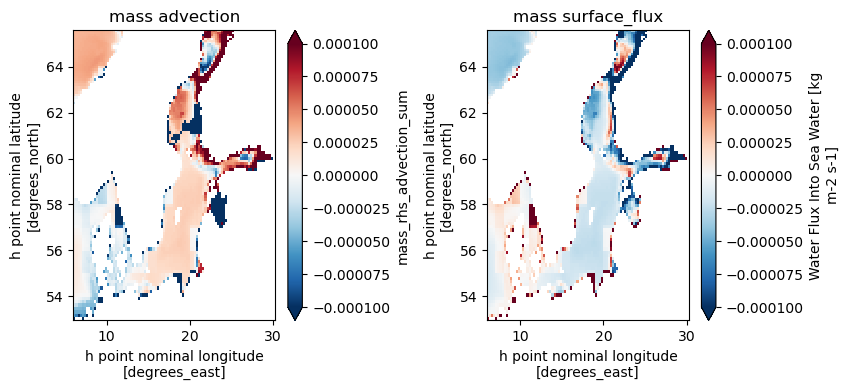

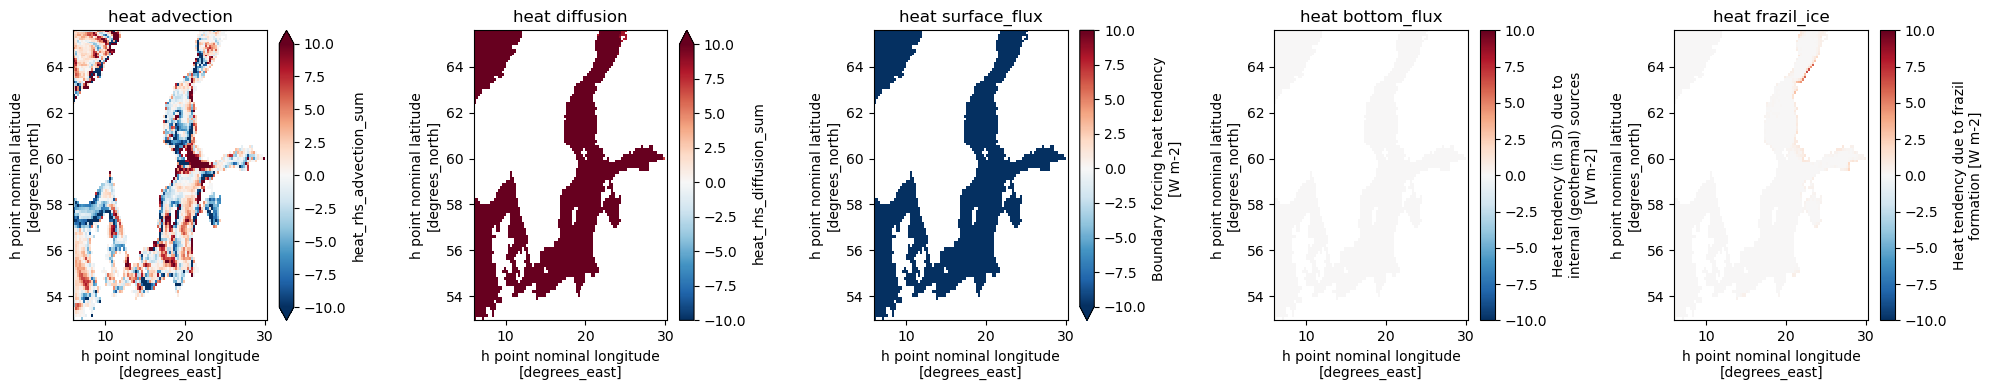

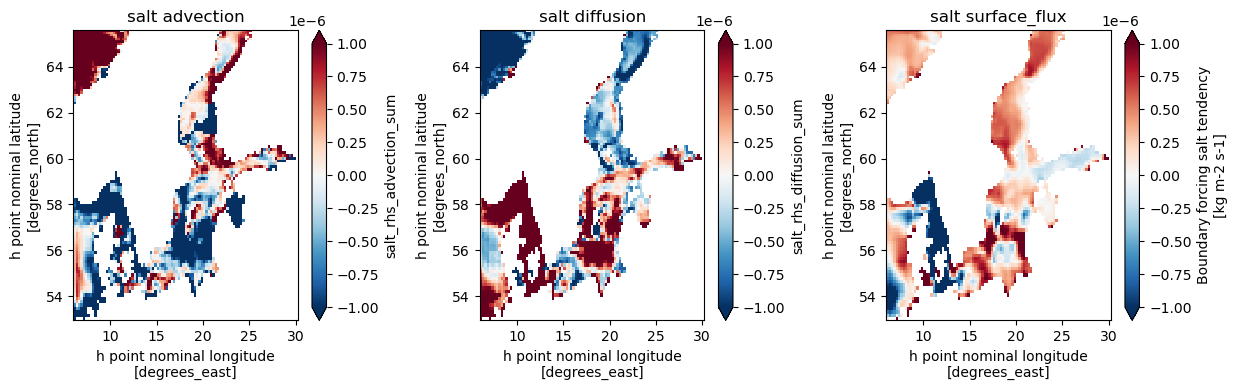

In [11]:
vmax = 1.e-4

for eq, vmax in zip(["mass", "heat", "salt"], [1.e-4, 10, 1.e-6]):
    plt.figure(figsize=(20, 4))

    for i, (k,v) in enumerate(simple_budgets[eq]['rhs'].items(), start=1):
        plt.subplot(1,len(simple_budgets['heat']['rhs']), i)
        if "zl" in ds[v].dims:
            ds[v].isel(zl = 0).isel(time=0).plot(vmin=-vmax, vmax=vmax, cmap="RdBu_r")
        else:
            ds[v].isel(time=0).plot(vmin=-vmax, vmax=vmax, cmap="RdBu_r")
        plt.title(f"{eq} {k}")

    plt.tight_layout()